
---


# **CS 4824/ECE 4424, Final Project**
---



# **1. Overview and Objective**
This Project is based on homework 4 using a convolutional neural network for image classification. The project will use the CIFAR100 dataset to train and validate specific categories in the data set that relate to elements found in yard to help identify objects that a robotic lawnmower might encouter during its operation. The goal is to manipluate the algorithm to determine the best parameters that achive the highest accuracy for these categories. 

In [23]:
from tensorflow import keras
from keras import optimizers
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

In [24]:
# parameters for this script
batch_size = 32
num_classes = 100
epochs = 25

## **2. Load the CIFAR100 dataset**

The **CIFAR100 dataset** is composed of of 50,000 *32x32* color training images and 10,000 test images, labeled over 100 categories. See more info at the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html). 

The `generate_data()` function imports the CIFAR100 dataset and returns the training set, validation set and test set.

**Returns** 

Tuple of NumPy arrays: `x_train, y_train, x_validate, y_validate, x_test, y_test`.

**x_train:** uint8 NumPy array of grayscale image data with shapes `(40000, 32, 32, 3)`, containing the training data. Pixel values range from 0 to 255.

**y_train:** uint8 NumPy array of labels (integers in range 0-9) with shape `(40000, 1)` for the training data.

**x_validate:** uint8 NumPy array of grayscale image data with shapes `(10000, 32, 32, 3)`, containing the test data. Pixel values range from 0 to 255.

**y_validate:** uint8 NumPy array of labels (integers in range 0-9) with shape `(10000, 1)` for the test data.

**x_test:** uint8 NumPy array of grayscale image data with shapes `(10000, 32, 32, 3)`, containing the test data. Pixel values range from 0 to 255.

**y_test:** uint8 NumPy array of labels (integers in range 0-9) with shape `(10000, 1)` for the test data.

In [25]:
def generate_data():
  # Load the data, split between train and test sets:
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # Convert class vectors to binary class matrices.
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)
  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

#  remove_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
#                  24, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
#                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 65, 66, 67, 68, 69]
  

#  for i in range(y_train.shape[0] - 40000):
#    for j in remove_classes:
#      if y_train[i][j] == 1:
#        x_train = np.delete(x_train, (i), axis=0)
#        y_train = np.delete(y_train, (i), axis=0)
#        break
  
#  for i in range(y_test.shape[0]):
#    for j in remove_classes:
#      if y_train[i][j] == 1:
#        np.delete(x_test, i)
#        np.delete(y_test, i)

#  print(x_train.shape[0])
#  print(x_test.shape[0])
  

  # partition training set into training and validation set
  x_validate = x_train[50000:,:]
  x_train = x_train[:50000,:]
  y_validate = y_train[50000:,:]
  y_train = y_train[:50000,:]
  

  return x_train, y_train, x_validate, y_validate, x_test, y_test

In [26]:
x_train, y_train, x_validate, y_validate, x_test, y_test = generate_data()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# **3. Visualize the data**
To better understand the dataset, let's plot the first 25 images from the training set:

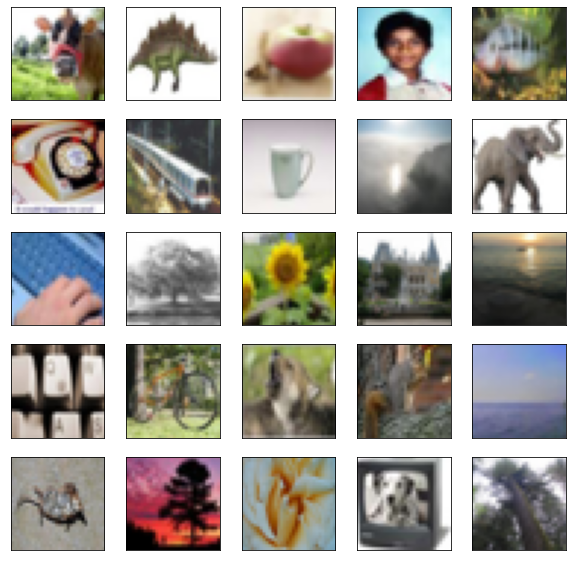

In [5]:


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    image = x_train[i]
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

## **4. The basic Convolutional Neural Network (CNN) architecture**

In [27]:
def base_cnn():
  """
  Define a convolutional neural network using the Sequential model. This is the 
  basic CNN that you will need to reuse for the remaining parts of the assignment.
  It would be good to familiarize yourself with the workings of this basic CNN.
  """
  model = Sequential()
  '''
  Add 2D convolution layers the perform spatial convolution over images. This 
  layer creates a convolution kernel that is convolved with the layer input to 
  produce a tensor of outputs. When using this layer as the first layer in a 
  model, provide the keyword argument 'input_shape' (tuple of integers). Besides,
  the Conv2D function takes as input
  - filters: Integer, the dimensionality of the output space (i.e. the number of
   output filters in the convolution). We set it to 32.
  - kernel_size: An integer or tuple/list of 2 integers, specifying the height
   and width of the 2D convolution window. Can be a single integer to specify 
   the same value for all spatial dimensions. We set it to (3, 3).

  Here, we create a stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function 
  '''
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perform MaxPooling operation for 2D spatial data. This downsamples the input
  along its spatial dimensions (height and width) by taking the maximum value 
  over an input window of size 2X2 for each channel of the input.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  '''
  Add a Dropout layer that  randomly sets input units to 0 with a frequency of
  'rate' at each step during training time, which helps prevent overfitting. 
  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all
  inputs is unchanged. We set the rate to 0.25 for Dropout.
  '''
  model.add(Dropout(0.25))
  '''
  Create another stack of (CONV2D, Activation, CONV2D, Activation) layers with 
  the ReLu activation function. Set the 'filters' to 64.
  '''
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  '''
  Perfrom MaxPooling and Dropout similar to the one defined earlier.
  '''
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  '''
  The image is still in 3D. It needs be unrolled from 3D to 1D using the Flatten
  layer. Then add a Dense layers on top of it followed by ReLu activation and 
  dropout of 0.5. This helps to create a fully-connected layer.
  '''
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  '''
  Create the output layer using the Dense layer with 'softmax' activation. The 
  number of predicted output needs to be equal to 'num_classes'.
  '''
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  '''
  Set the optimizer for doing mini-batch gradient descent. Here, we make use of 
  the RMSprop optimizer that comes with Keras. We supply some default values for
  the parameters learning_rate and decay. Do not modify them.
  '''
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  '''
  Compile the model for training. Since this is a multi-class classification 
  problem, we use the 'categorical_crossentropy' loss function and 'accuracy' as
  the desired performance metric.
  '''
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

## **5. Activation functions for CNN**

### **a) Compare the activation fuctions ReLu**

In this section, we see the effect of changing the activation functions in the above CNN architecture.



In [21]:
def base_cnn_activation(activation):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation(activation))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation(activation))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(activation))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(activation))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(activation))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate this scenario


Training CNN with relu activation function
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
             

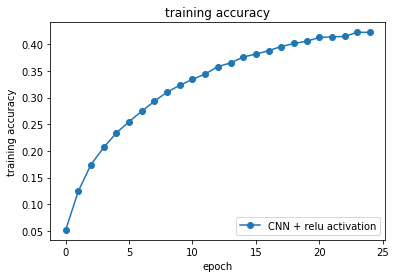

KeyError: ignored

In [8]:
# create a callback that will save the best model while training
history_activations = dict()

for activation in ['relu']:
  print('Training CNN with {} activation function'.format(activation))
  save_best_model = ModelCheckpoint('best_model.{}'.format(activation), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model =  base_cnn_activation(activation)
  history_activations[activation] = model.fit(x_train, y_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              validation_data=(x_validate, y_validate),
                                              shuffle=True,
                                              callbacks=[save_best_model])
# Plot training accuracy
for activation in ['relu']:
  plt.plot(history_activations[activation].history['accuracy'], 'o-', label='CNN + {} activation'.format(activation))

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
for activation in ['relu',]:
  plt.plot(history_activations[activation].history['val_accuracy'], 'o-', label='CNN + {} activation'.format(activation))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for activation in ['relu']:
  saved_model = load_model('best_model.{}'.format(activation))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for {} activation: {}'.format(activation, scores[1]))

### **b) Comparing activation functions Sigmoid**

Training CNN with sigmoid activation function
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
        

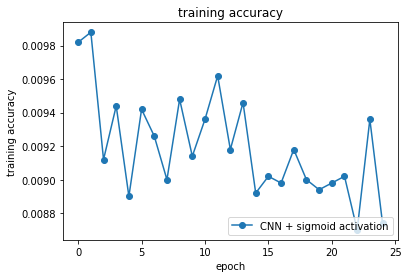

KeyError: ignored

In [15]:
# create a callback that will save the best model while training
history_activations = dict()

for activation in ['sigmoid']:
  print('Training CNN with {} activation function'.format(activation))
  save_best_model = ModelCheckpoint('best_model.{}'.format(activation), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model =  base_cnn_activation(activation)
  history_activations[activation] = model.fit(x_train, y_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              validation_data=(x_validate, y_validate),
                                              shuffle=True,
                                              callbacks=[save_best_model])
# Plot training accuracy
for activation in ['sigmoid']:
  plt.plot(history_activations[activation].history['accuracy'], 'o-', label='CNN + {} activation'.format(activation))

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
for activation in ['sigmoid',]:
  plt.plot(history_activations[activation].history['val_accuracy'], 'o-', label='CNN + {} activation'.format(activation))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for activation in ['sigmoid']:
  saved_model = load_model('best_model.{}'.format(activation))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for {} activation: {}'.format(activation, scores[1]))

### **c) Comparing activation functions tanh**

Training CNN with tanh activation function
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
           

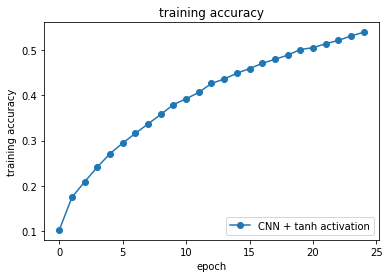

KeyError: ignored

In [22]:
# create a callback that will save the best model while training
history_activations = dict()

for activation in ['tanh']:
  print('Training CNN with {} activation function'.format(activation))
  save_best_model = ModelCheckpoint('best_model.{}'.format(activation), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model =  base_cnn_activation(activation)
  history_activations[activation] = model.fit(x_train, y_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              validation_data=(x_validate, y_validate),
                                              shuffle=True,
                                              callbacks=[save_best_model])
# Plot training accuracy
for activation in ['tanh']:
  plt.plot(history_activations[activation].history['accuracy'], 'o-', label='CNN + {} activation'.format(activation))

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Plot validation accuracy
for activation in ['tanh',]:
  plt.plot(history_activations[activation].history['val_accuracy'], 'o-', label='CNN + {} activation'.format(activation))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for activation in ['tanh']:
  saved_model = load_model('best_model.{}'.format(activation))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for {} activation: {}'.format(activation, scores[1]))

## **6. The effects of dropout on CNN**





In [12]:
def base_cnn_drop(dropout):

  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('tanh'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  if dropout:
    model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if dropout:
    model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('tanh'))
  if dropout:
    model.add(Dropout(0.5))
  
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())

  return model

### Test code to simulate this scenario

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

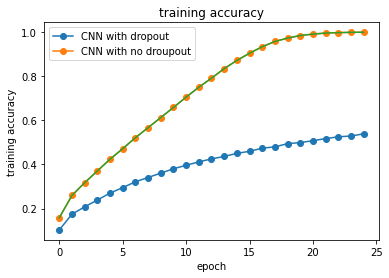

KeyError: ignored

In [13]:
history_dd = dict()

for dropout in [True, False]:
  model = base_cnn_drop(dropout)
  model_name = ('no droupout', 'dropout')[dropout]
  save_best_model = ModelCheckpoint('best_model.{}'.format(model_name),
                                    monitor='val_accuracy', mode='max',
                                    save_best_only=True, verbose=1)

  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_validate, y_validate),
                      shuffle=True,
                      callbacks=[save_best_model])
  
  history_dd[model_name] = history


# Plot training accuracy
for model_name, history in history_dd.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN with {}'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_dd.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN with {}'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for model_name in history_dd.keys():
  saved_model = load_model('best_model.{}'.format(model_name))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN with {} :'.format(model_name, scores[1]))

## **7. The effects of optimizers on the CNN**

### **a) Compare the accuracy achieved when training the basic CNN with RMSprop, Adagrad and Adam**. 

In [21]:
def base_cnn_opt(optimizer):

  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('tanh'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('tanh'))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('tanh'))
  model.add(Dropout(0.5))
  
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  if (optimizer == 'RMSprop'):
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
  if (optimizer == 'Adam'):
    opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
  if (optimizer == 'Adagrad'):
    opt = keras.optimizers.Adagrad(learning_rate=0.0001, decay=1e-6)
  
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())
  

  return model

### Test code to simulate the scenario


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_18 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_19 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                      

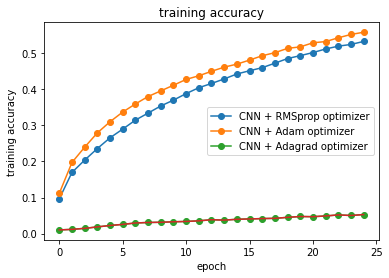

KeyError: ignored

In [22]:
history_opt = dict()

for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  save_best_model = ModelCheckpoint('best_model.{}'.format(optimizer), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
  model = base_cnn_opt(optimizer)
  history_opt[optimizer] = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_validate, y_validate),
                          shuffle=True,
                          callbacks=[save_best_model])

# Plot training accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
for model_name, history in history_opt.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='CNN + {} optimizer'.format(model_name))
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for optimizer in ['RMSprop', 'Adam', 'Adagrad']:
  saved_model = load_model('best_model.{}'.format(optimizer))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN + {} optimizer: {}'.format(optimizer, scores[1]))

## **9. The effects of convolutional filters on the CNN**

### **a) Compare the base CNN with 3x3 filters against a modified CNN with 5x5 filters**

In [28]:
def new_cnn():

  model = Sequential()

  model.add(Conv2D(32, (5, 5), padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('tanh'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Dropout(0.25))

  model.add(Conv2D(64, (5, 5), padding='same'))
  model.add(Activation('tanh'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('tanh'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
 
  opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  print(model.summary())



  return model

### Test code to simulate the scenario (**do not modify**)

**Expected runtime on Google Colab:** 30-60 minutes with TPU/GPU resources

Training the base CNN
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_36 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_37 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                

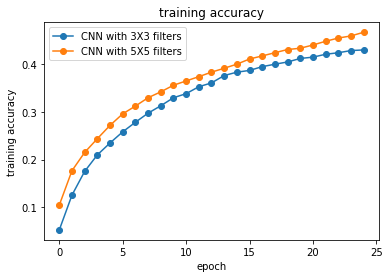

KeyError: ignored

In [29]:
# create a callback that will save the best model while training
history_cnns = dict()

for cnn in ['base', 'new']:
  print('Training the {} CNN'.format(cnn))
  save_best_model = ModelCheckpoint('best_model.{}'.format(cnn), monitor='val_accuracy',
                                    mode='max', save_best_only=True, verbose=1)
  if cnn == 'base':
    model =  base_cnn()
  else:
    model = new_cnn()
    
  history_cnns[cnn] = model.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_validate, y_validate),
                                shuffle=True,
                                callbacks=[save_best_model])
# Plot training accuracy
plt.plot(history_cnns['base'].history['accuracy'], 'o-', label='CNN with 3X3 filters')
plt.plot(history_cnns['new'].history['accuracy'], 'o-', label='CNN with 5X5 filters')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
plt.plot(history_cnns['base'].history['val_accuracy'], 'o-', label='CNN with 3X3 filters')
plt.plot(history_cnns['new'].history['val_accuracy'], 'o-', label='CNN with 5X5 filters')

plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
for cnn in ['base', 'new']:
  saved_model = load_model('best_model.{}'.format(cnn))
  scores = saved_model.evaluate(x_test, y_test, verbose=1)
  print('Test accuracy for CNN with {} filters: {}'.format(('3X3', '5X5')[cnn=='new'], scores[1]))